In [1]:
import intake
import healpy as hp
import cmocean
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

import easygems.healpix as egh
import seaborn as sns

In [2]:
Lv = 2.5e6
cp = 1004.
Rd = 287.05
grav = 9.81

data_path = './data'

# ERA5 from DKRZ
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
era5 = cat.HERA5(time="P1D").to_dask()
era5

/home/u12590/miniconda-x86_64/envs/orcestra_env/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 2TB
Dimensions:    (time: 4991, cell: 196608, level: 29, crs: 1)
Coordinates:
  * crs        (crs) float64 8B nan
    latitude   (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
  * level      (level) int64 232B 50 70 100 125 150 175 ... 900 925 950 975 1000
    longitude  (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
  * time       (time) datetime64[ns] 40kB 2010-01-01T12:00:00 ... 2023-08-31T...
Dimensions without coordinates: cell
Data variables: (12/72)
    100u       (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    100v       (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    10u        (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    10v        (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    2d         (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    2t         (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    ...         ...
    isor       (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    lsm        (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    sdfor      (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    sdor       (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    slor       (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    z_sfc      (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
Attributes:
    acknowledgment:  Contains modified Copernicus Climate Change Service info...
    contact:         lukas.kluft@mpimet.mpg.de
    creator:         Lukas Kluft
    description:     Selected variables from ERA5, restructured and saved on ...
    institution:     Max Planck Institute for Meteorology
    source:          Post-processed dataset based on the ERA5 mirror located ...
    title:           HERA5 - HEALPixelation of ERA5

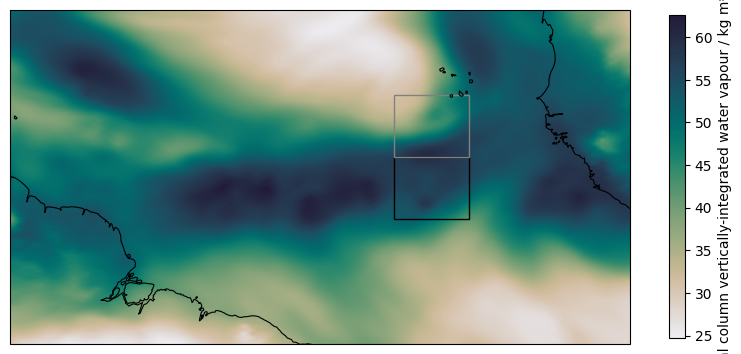

In [3]:
# Selecting the orcestra region and time
# (from https://orcestra-campaign.org/hera5.html)
# [W, E, S, N]
import matplotlib.patches as patches

extent_orcestra = [-60, -10, -5, 20]
extent_orcestra_cabo_s = [-29, -23, 5, 10] # Cabo => Southern domain
extent_orcestra_cabo_n = [-29, -23, 10, 15] # Cabo => Northern domain

is_orcestra = egh.isel_extent(era5, extent_orcestra)
var = era5["tcwv"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent(extent_orcestra)
ax.coastlines(lw=0.8)
im = egh.healpix_show(
    var.sel(time="2020-08-01").values,
    method="linear",
    cmap="cmo.rain",
#     vmin=0,
)
fig.colorbar(im, label=f"{var.long_name} / {var.units}", shrink=0.7)

# Southern domain
rect_s = patches.Rectangle((extent_orcestra_cabo_s[0], extent_orcestra_cabo_s[2]), # origin
                           extent_orcestra_cabo_s[1] - extent_orcestra_cabo_s[0], # width
                           extent_orcestra_cabo_s[3] - extent_orcestra_cabo_s[2], # heigh
                           linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect_s)

# Northern domain
rect_n = patches.Rectangle((extent_orcestra_cabo_n[0], extent_orcestra_cabo_n[2]), # origin
                           extent_orcestra_cabo_n[1] - extent_orcestra_cabo_n[0], # width
                           extent_orcestra_cabo_n[3] - extent_orcestra_cabo_n[2], # heigh
                           linewidth=1, edgecolor='grey', facecolor='none')
ax.add_patch(rect_n)

plt.savefig(data_path+'/figures/analysis-domain.png', dpi=300, bbox_inches='tight')

In [4]:
def create_era5env(era5, variables, extent, months):
    
    icell = egh.isel_extent(era5, extent)

    era5_env = era5[variables].sel(cell=icell).isel(time=era5.time.dt.month.isin(months))

    era5_env['height'] = era5_env['z'] / grav # geopotential => height
    era5_env['pres'] = era5_env['level'] * 100 # hPa => Pa

    # Conversions
    era5_env['theta_l']  = (1e5/era5_env['pres'])**(2/7)*(era5_env['t'] - Lv/cp*era5_env['clwc']) # FIXME Ignores rain, ice, snow
    era5_env['theta_l_s'] = (1e5/era5_env['pres'])**(2/7)*era5_env['sst'] # Assuming qts = qtsat and thus qls = 0.
    era5_env['rho'] = era5_env['pres']/Rd/era5_env['t'] # Dry approximation, is that okay?
    era5_env['ws'] = -era5_env['w']/era5_env['rho']/grav # w = -\omega/(g\rho)
    era5_env['U'] = np.sqrt(era5_env['u']**2 + era5_env['v']**2)
    era5_env['qs'] = era5_env['q'] / (era5_env['r'] / 100)
    
    # Make mean vertical profiles

    # Let's assume we can interchange the time/space mean pressure levels with a uniform horizontal coordinate
    # This isn't entirely accurate (see below, z varies around a pressure level with std ~10-50 m around 10 km)
    # But that's even below the grid spacing we'll use, so I'll take it for now
    # era5_env['height'].mean(['cell', 'time']).plot(y='level')
    # plt.show()
    # era5_env['height'].mean('cell').std('time').plot(y='level')
    era5_env['zm'] = era5_env['height'].mean(['cell', 'time'])
    era5_env = era5_env.set_coords(['zm']).swap_dims({'level':'zm'})
    
    return era5_env

In [5]:
# Compute and download locally for future analysis (takes a few min)

variables = ['z', 'q', 'r', 'clwc', 't', 'u', 'v', 'w', 'sst', 'sp', 'd']
months_orcestra = [7, 8, 9]
download = False

# Southern domain
era5_env_s = create_era5env(era5, variables, extent_orcestra_cabo_s, months_orcestra)

# Northern domain
era5_env_n = create_era5env(era5, variables, extent_orcestra_cabo_n, months_orcestra)

if download:
    era5_env_s.to_netcdf(data_path+'/era5_env_s.nc', mode='w')
    era5_env_s = xr.open_dataset(data_path+'/era5_env_s.nc')
    
    era5_env_n.to_netcdf(data_path+'/era5_env_n.nc', mode='w')
    era5_env_n = xr.open_dataset(data_path+'/era5_env_n.nc')
else:
    era5_env_s = xr.open_dataset(data_path+'/era5_env_s.nc')
    era5_env_n = xr.open_dataset(data_path+'/era5_env_n.nc')

era5_env_s_mn = era5_env_s.mean(dim=['cell','time'])
era5_env_s_25 = era5_env_s.quantile(0.25, dim=['cell','time'])
era5_env_s_75 = era5_env_s.quantile(0.75, dim=['cell','time'])

era5_env_n_mn = era5_env_n.mean(dim=['cell','time'])
era5_env_n_25 = era5_env_n.quantile(0.25, dim=['cell','time'])
era5_env_n_75 = era5_env_n.quantile(0.75, dim=['cell','time'])

if download:
    era5_env_s_mn.to_netcdf(data_path+'/era5_env_s_mn.nc', mode='w')
    era5_env_n_mn.to_netcdf(data_path+'/era5_env_n_mn.nc', mode='w')

In [6]:
# Interpolate the data onto a lat/lon grid
from utils import interpolate_to_latlon

era5_env_s_ll = interpolate_to_latlon(era5_env_s)
era5_env_n_ll = interpolate_to_latlon(era5_env_n)